<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

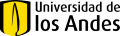

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Mini Proyecto 2, Técnicas de *Deep Learning*: Clasificación de Sentimientos de Reseñas de Películas en *IMDB* con Redes Neuronales Recurrentes**

## **Descripción del problema:**

En este proyecto abordamos el problema de clasificación de sentimiento en reseñas de películas. Partimos de un conjunto de datos extraído de Kaggle que contiene reseñas textuales (**`text`**) y una etiqueta binaria (**`label`**) que indica si la opinión es positiva (**1**) o negativa (**0**). El reto consiste en diseñar un modelo de *Deep Learning*, concretamente una Red Neuronal Recurrente con capas LSTM, capaz de procesar secuencias de texto y predecir con alta precisión la polaridad de cada reseña.

## **Objetivo:**

* Implementar un *pipeline* completo que incluya la descarga del dataset, el preprocesamiento de texto (tokenización, limpieza, construcción de vocabulario y padding de secuencias), y la definición de un Dataset y DataLoader en PyTorch.

* Diseñar una arquitectura basada en *embeddings* y una o varias capas LSTM (bidireccionales), con regularización por *dropout* y optimización con **`Adam`**.

* Entrenar el modelo utilizando GPU cuando esté disponible, incorporando técnicas de *early stopping* y gradient clipping para evitar sobreajuste y explosión de gradientes.

* Evaluar su desempeño final sobre el conjunto de prueba, calculando *accuracy*, *F1‑score*, *recall* y presentando la matriz de confusión.

* Visualizar la evolución de la pérdida y la exactitud en entrenamiento y validación a lo largo de las épocas.

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 9 de mayo.**


***
# Tareas

* Exploración y pre-procesamiento (Jordan)

* Introducción, y explicación de las opciones tomadas en el PDF (Andrés y Jordan)

* Comentarios en código, explicaciones en markdowns (Andrés y Jordan)

* Nube de Palabras (Jordan) ✅

* Validación de idiomas (Jordan) ✅

* Glove  (Jordan)

* Word2vec (Andrés) ✅

* LSTM o GRU  (Andrés) ✅

* Mejorar red (Andrés) ✅

* Pensar en ideas visualización (Andrés y Jordan)
- t-SNE

* Entrenamiento y evaluación de modelo (Andrés) ✅

* Informe: Arquitectura, entrenamiento, evaluación, análisis cuantitativo (Andrés)

* Informe: Exploración, pre-procesamiento, análisis cualitativo, discusión (Jordan)


***
# **Índice**

El *notebook* abordará el proyecto de la siguiente manera:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣ | **Instalación y carga de librerías** |
| 2️⃣ | **Análisis exploratorio y preparación de los datos**       |
| 3️⃣ | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣ | **Pipeline de preprocesamiento ...**   |
| 4️⃣ | **Desarrollo del modelo RNN...**   |
| 4️⃣.1️⃣ | **Hiperparámetros, partición y Dataloaders**   |
| 4️⃣.2️⃣ | **Adaptación a partir de la arquitectura ...*   |
| 4️⃣.3️⃣ | **Entrenamiento, validación y prueba**   |
| 5️⃣ | **Análisis de resultados y conclusiones**   |
| 6️⃣ | **Conclusión**   |
| 7️⃣ | **Referencias**   |


***

# 1. Instalación y cargue de librerías

Después de la instalación de algunas librerías se importan utilidades generales (**`os`**, **`random`**,**`time`**, **`NumPy`**, **`pandas`**), herramientas de PLN con **`NLTK`** (incluida la descarga de *stop-words*), módulos de **`PyTorch`** para construir y entrenar la red, métricas de **`scikit-learn`** y utilidades de visualización con **`Matplotlib`** y **`Seaborn`**. Por último, importa la librería **`huggingface_hub`** para más adelante descargar uno de los embeddings.

In [19]:
# Instalación de librerías para colab
%pip install -q --no-cache-dir kagglehub langdetect
%pip install -q --no-cache-dir huggingface_hub

In [20]:
# Librerías comunes
import os
import random
import time
import numpy as np
import pandas as pd
import time

# Descarga de datasets y de embeddings
import kagglehub
from huggingface_hub import hf_hub_download

# Preprocesamiento, NLP
from collections import Counter
from langdetect import detect
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
# Palabras vacías
nltk.download('stopwords')

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

# Evaluación
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from tqdm import tqdm

# Librerías para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se importa **`kagglehub`** y ejecuta **`dataset_download`** con el identificador **`yasserh/imdb-movie-ratings-sentiment-analysis`** para descargar el conjunto de datos de reseñas de películas IMDB. La función guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

In [21]:
path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")
print("Datos descargados en:", path)

Datos descargados en: /kaggle/input/imdb-movie-ratings-sentiment-analysis


Se carga los *embeddings* de los *tokens* de los documentos, que nos permitirán tener un nuevo espacio de representación más enriquecido. Más adelante se explica con más detalle cada tipo de *embedding*.

### Word2Vec

In [22]:
bin_path = hf_hub_download(repo_id =
            "NathaNn1111/word2vec-google-news-negative-300-bin",
            filename = "GoogleNews-vectors-negative300.bin")
print("Embeddings en:", bin_path)

Embeddings en: /root/.cache/huggingface/hub/models--NathaNn1111--word2vec-google-news-negative-300-bin/snapshots/78856d4586b3a938134c9833d92139f2e056e369/GoogleNews-vectors-negative300.bin


### GloVe

In [ ]:
!wget -P . http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip -d .

In [23]:
embeddings = {}

with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = [float(x) for x in parts[1:]]
        embeddings[word] = vector
print(f"Loaded {len(embeddings)} word vectors.")

Loaded 400000 word vectors.


Este bloque detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  
Primero se llama a **`torch.cuda.is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al runtime de Colab. Según el resultado se imprime un mensaje informativo (“Entrenando en GPU.” o “GPU no disponible, entrenando en CPU.”).  

A continuación se construye el objeto **`device`** con **`torch.device("cuda" if train_on_gpu else "cpu")`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [24]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Entrenando en GPU.")
else:
    print("GPU no disponible, entrenando en CPU.")

# 2) Elegir device según disponibilidad
device = torch.device("cuda" if train_on_gpu else "cpu")
print(f"   Usando device: {device}\n")

GPU no disponible, entrenando en CPU.
   Usando device: cpu



Este bloque hace dos tareas sencillas de soporte:

1. Llama a **`warnings.filterwarnings("ignore")`** para ocultar avisos y mantener la salida del notebook limpia.
2. Utiliza **`importlib.metadata.version`** para imprimir las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`torchvision`**, **`scikit-learn`**, **`kagglehub`**, **`pillow`**, **`matplotlib`**, **`seaborn`** ). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [25]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = [
    "numpy", "pandas", "torch", "torchvision", "scikit-learn", "kagglehub",
    "pillow", "matplotlib", "seaborn",
    "nltk", "tqdm", "scipy"
]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
torchvision :  0.21.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
pillow :  11.2.1
matplotlib :  3.10.0
seaborn :  0.13.2
nltk :  3.9.1
tqdm :  4.67.1
scipy :  1.15.2


El siguiente bloque de código nos permite hacer determininísticas las funciones traídas de **`pytorch`**, y en general controlar todos los pseudo-aleatorios del *notebook*

In [26]:
# Definición del random state y seeds
RANDOM_STATE = 13
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [27]:
# Descargar el conjunto de datos y almacenar el path en una variable
data_raw = pd.read_csv(os.path.join(path, 'movie.csv'))
data_raw.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [28]:
label2index = {'Negativa':0, 'Positiva':1}
index2label = {0:'Negativa', 1:'Positiva'}

In [29]:
# Frecuencias absoluta y relativa de cada clase
pd.DataFrame({
    "Review": index2label,
    "F. Absoluta": data_raw['label'].value_counts().sort_index(),
    "F. Relativa": data_raw['label'].value_counts(normalize=True).sort_index(),
})

,Review,F. Absoluta,F. Relativa
0,Negativa,20019,0.500475
1,Positiva,19981,0.499525


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [30]:
data_raw.isna().sum()

,0
text,0
label,0


In [31]:
data_raw.duplicated().sum()

np.int64(277)

In [32]:
data = data_raw.drop_duplicates(keep='first')

# Frecuencias absoluta y relativa de cada clase
pd.DataFrame({
    "Review": index2label,
    "F. Absoluta": data['label'].value_counts().sort_index(),
    "F. Relativa": data['label'].value_counts(normalize=True).sort_index(),
})

,Review,F. Absoluta,F. Relativa
0,Negativa,19815,0.498829
1,Positiva,19908,0.501171


⚠️ La siguiente función tarda ~4 mins en ejecutarse y la mayoría de veces no detecta otros idiomas. Quizá solo podríamos mencionar que hemos corrido esta validación anteriormente y no hemos encontrado un número significativo de textos en otros idiomas ⚠️

In [33]:
def detectar_idiomas(X: pd.DataFrame):
  #Identificar los idiomas del dataframe y los índices de las filas que no están en inglés
  X['idioma'] = X['text'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else "desconocido")
  indices_a_traducir = X[X['idioma'] != 'en'].index

  # Imprimir textos en otros idiomas
  print("Textos en otros idiomas:")
  for i in indices_a_traducir:
    print(X.loc[i].text)

  # Retornar el df ahora con la columna 'idioma'
  return X

In [34]:
%time data = detectar_idiomas(data)
data.idioma.value_counts()

Textos en otros idiomas:
CPU times: user 3min 59s, sys: 2.19 s, total: 4min 1s
Wall time: 4min 21s


,count
idioma,
en,39723


El objetivo de esta sección es incorporar varios estilos de pre-procesamiento, probar diferentes maneras de depurar los textos como por ejemplo remover caracteres no alfanuméricos, a excepción de guiones o apóstrofes. También haremos uso de dos normalizadores: *Stemming* y *Lemmatization*, ....

***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

Se construye el conjunto **`english_stop`** a partir de las *stop-words* inglesas de **`NLTK`** y se define la función **`clean_and_tokenize`** [¹]:

In [40]:
english_stop = set(stopwords.words('english'))

def clean_and_tokenize(text):
    # extrae solo palabras alfabéticas
    tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    return [t for t in tokens if t not in english_stop]

# Prueba
example = data.loc[0, 'text']
print(clean_and_tokenize(example))

['grew', 'b', 'watching', 'loving', 'thunderbirds', 'mates', 'school', 'watched', 'played', 'thunderbirds', 'school', 'lunch', 'school', 'wanted', 'virgil', 'scott', 'one', 'wanted', 'alan', 'counting', 'became', 'art', 'form', 'took', 'children', 'see', 'movie', 'hoping', 'would', 'get', 'glimpse', 'loved', 'child', 'bitterly', 'disappointing', 'high', 'point', 'snappy', 'theme', 'tune', 'could', 'compare', 'original', 'score', 'thunderbirds', 'thankfully', 'early', 'saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'series', 'gerry', 'anderson', 'wife', 'created', 'jonatha', 'frakes', 'hand', 'directors', 'chair', 'version', 'completely', 'hopeless', 'waste', 'film', 'utter', 'rubbish', 'cgi', 'remake', 'may', 'acceptable', 'replacing', 'marionettes', 'homo', 'sapiens', 'subsp', 'sapiens', 'huge', 'error', 'judgment']


Se construye el vocabulario y define la función de codificación:

1. **`all_tokens`** concatena todos los tokens de las reseñas ya limpiadas.  
2. Con **`Counter`** se calcula **`freq`**, el conteo de frecuencia de cada token.  
3. Se crea **`vocab`** guardando las 20 000 palabras más frecuentes y asignando
   índices a partir del 2; los índices **`0`** y **`1`** quedan reservados para los
   símbolos especiales **`<PAD>`** y **`<UNK>`** que se añaden después.
4. **`encode(tokens, max_len=200)`** convierte una lista de tokens en su
   representación numérica mediante el diccionario **`vocab`**.  
   - Cada palabra se mapea a su índice; las fuera de vocabulario usan **`1`**  
     (**`<UNK>`**).  
   - La secuencia resultante se recorta a **`max_len`** y se rellena con **`0`**
     (**`<PAD>`**) hasta alcanzar exactamente esa longitud.


In [41]:
all_tokens = [tok for txt in data['text'] for tok in clean_and_tokenize(txt)]
freq = Counter(all_tokens)

# Top‑20 000 + <PAD>=0, <UNK>=1
vocab = {w:i+2 for i,(w,_) in enumerate(freq.most_common(20000))}
#Indicadores de inicio y final
vocab.update({'<PAD>':0,'<UNK>':1})

def encode(tokens, max_len=200):
    seq = [vocab.get(t,1) for t in tokens]
    # Completa secuencia hasta tener max_len
    return seq[:max_len] + [0]*(max_len-len(seq))

La función **`load_google_vectors_bin`** genera la matriz de pesos que inicializará la capa **`Embedding`** del modelo:

In [43]:
# 1. Carga Word2Vec
def load_google_vectors_bin(bin_file: str,
                            vocab: dict[str, int],
                            emb_dim: int = 300) -> np.ndarray:
    """
    Lee el fichero Word2Vec binario de Google News y devuelve la matriz
    de pesos (|vocab| × emb_dim) lista para nn.Embedding.
    Solo extrae los vectores de las palabras presentes en `vocab`;
    el resto se inicializa aleatoriamente (N(0, 0.6²)).
    """
    matrix = np.random.normal(scale=0.6,
                              size=(len(vocab), emb_dim)
                             ).astype(np.float32)

    with open(bin_file, "rb") as f:
        # Cabecera:  "3000000 300\n"
        header = f.readline()
        total_words, dim = map(int, header.split())
        assert dim == emb_dim, "Dimensión de embedding inesperada"

        binary_len = emb_dim * 4  # 4 bytes • float32
        for _ in range(total_words):
            # 1) Leer palabra (bytes hasta el primer espacio)
            word_bytes = []
            while True:
                ch = f.read(1)
                if ch == b' ':          # separador palabra-vector
                    word = b"".join(word_bytes).decode("utf-8", "ignore")
                    break
                if ch != b'\n':         # el \n solo aparece en la cabecera
                    word_bytes.append(ch)

            # 2) Leer los 300 float32 (secuencia de 1200 bytes)
            vec = np.frombuffer(f.read(binary_len), dtype=np.float32)

            # 3) Copiar si la palabra está en nuestro vocabulario
            if word in vocab:
                matrix[vocab[word]] = vec

    return matrix


%time w2v_weights = load_google_vectors_bin(bin_path, vocab, emb_dim=300)

CPU times: user 16.2 s, sys: 2.76 s, total: 19 s
Wall time: 23.1 s


Se construye la matriz **`w2v_weights`** aplicando **`load_google_vectors_bin`** al modelo *Word2Vec GoogleNews*. Este modelo contiene 3 millones de vectores de 300 dimensiones entrenados con el algoritmo skip-gram con negative sampling sobre ≈ 100 mil millones de palabras del corpus Google News. Los autores sustituyeron las redes n-gram tradicionales por dos arquitecturas sencillas (CBOW y Skip-gram) con optimizaciones como negative sampling y sub-sampling de palabras frecuentes. Esto permitió entrenar embeddings de alta calidad en horas, no en días [²].

Esto vectores se cracteríza por capturar relaciones aditivas (“king − man + woman ≈ queen”) y mejoraron sustancialmente las tareas de analogías y similitud frente a métodos previos. Es un amplio vocabulario y la granularidad de 300 dimensiones hacen que todavía sea un punto de partida competitivo para tareas de PLN en inglés, sobre todo cuando el corpus propio es pequeño o se busca ahorrar tiempo de entrenamiento.

Nube de palabras

In [44]:
def generar_wordcloud(X: pd.DataFrame):

  # Foo
  X_preprocesado = X.text.apply(lambda x: clean_and_tokenize(x))
  texto_nube = ' '.join(w for text in X_preprocesado for w in text)

  # Generación Nube de Palabras
  wordcloud = WordCloud(
      width=800,
      height=400,
      background_color ='white',
      min_font_size=10,
      max_font_size=110,
      max_words=100
  ).generate(texto_nube)
  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

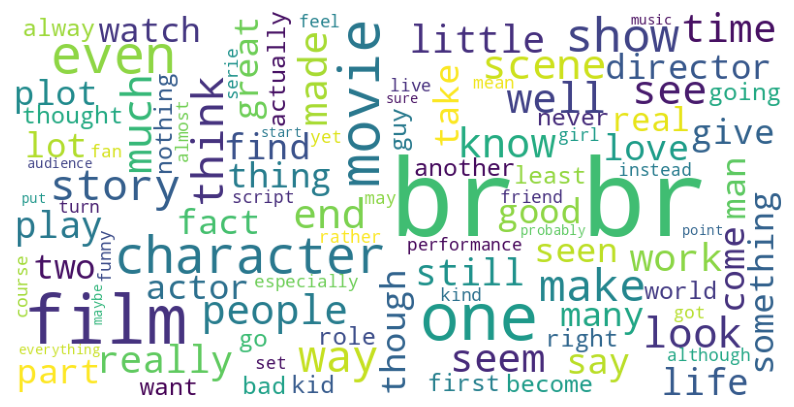

CPU times: user 46.8 s, sys: 2.17 s, total: 49 s
Wall time: 53.1 s


In [45]:
%time generar_wordcloud(data)

***

# 4. Desarrollo del modelo RNN....

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

Se crea un **`IMDBDataset`** que toma cada reseña del **`DataFrame`**, la limpia, la tokeniza, la codifica a 200 índices con **`padding`** y entrega la pareja tensor entero + etiqueta flotante , lista para **`nn.BCELoss`**. Con una semilla fija se divide el conjunto en **`80 %–10 %–10 %`** (entrenamiento, validación y prueba) y cada segmento se coloca en un **`DataLoader`** de lote 64, barajado solo en entrenamiento.

In [46]:
class IMDBDataset(Dataset):
    def __init__(self, df, max_len=200):
        self.texts  = df['text'].tolist()
        self.labels = df['label'].astype(int).tolist()
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        toks = clean_and_tokenize(self.texts[i])
        return torch.tensor(encode(toks,self.max_len)), torch.tensor(self.labels[i],dtype=torch.float)

# Split 80/10/10 con semilla fija
ds = IMDBDataset(data)
n = len(ds)
train_ds, val_ds, test_ds = random_split(ds, [int(.8*n),int(.1*n),n-int(.9*n)], generator=torch.Generator().manual_seed(RANDOM_STATE))

batch_size = 64 #Batch grande
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size, shuffle=False)

**`SentimentRNN`**, derivada de **`Module`**, integra cuatro componentes clave en un único flujo [³]. Primero aparece la capa de *embeddings*: si se suministran **`pretrained_weights`**, estos vectores se cargan mediante **`Embedding.from_pretrained`** y pueden mantenerse fijos o descongelarse según convenga; de lo contrario, se crea un **`Embedding`** estándar con el tamaño del vocabulario. A continuación se encuentra la LSTM, configurable en dimensión oculta, número de capas y bidireccionalidad. Cuando se activa el modo bidireccional, el modelo recorre cada secuencia tanto en su orden natural como en sentido inverso, capturando dependencias de corto y largo alcance, y aplica *dropout* interno entre capas para mejorar la generalización.

Tras procesar la secuencia, se conserva únicamente el último estado temporal —que ya sintetiza la información más relevante— y se le aplica un **`Dropout`** externo como medida adicional contra el sobre‑ajuste. Finalmente, una capa totalmente conectada reduce la representación a un valor escalar que **`sigmoid`** transforma en la probabilidad de que la reseña sea positiva. El método **`forward`** encadena estos pasos y devuelve el resultado aplanado con **`.squeeze`** para facilitar la comparación con la etiqueta.

---

La preferencia por LSTM sobre alternativas como GRU responde a tres factores complementarios. Primero, las reseñas de IMDb rondan los 200 *tokens*, por lo que las dependencias de largo plazo resultan importantes y la memoria explícita de la LSTM ofrece una ventaja. Segundo, el tamaño del corpus es lo bastante grande como para entrenar un modelo con más parámetros sin incurrir en sobre‑ajuste excesivo, especialmente con las técnicas de *dropout* ya mencionadas. Tercero y decisivo, un estudio reciente muestra que en este mismo conjunto de datos la LSTM supera consistentemente a la GRU en *accuracy*, corroborando hallazgos anteriores [⁴]. A la luz de esta evidencia y de los requisitos de desempeño del proyecto, la LSTM se presenta como la opción más sólida.

In [47]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=300, hid_dim=128, n_layers=3, bidir=True, drop=0.6, pretrained_weights=None):
        super().__init__()
        #Capa de embedding
        if pretrained_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(pretrained_weights),
                freeze=True,
                padding_idx=0
            )
        else:
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # RNN
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, bidirectional=bidir, batch_first=True, dropout=drop if n_layers > 1 else 0.0)
        # Droput
        self.dropout = nn.Dropout(drop)
        # Red completamente conectada
        self.fc = nn.Linear(hid_dim*(2 if bidir else 1), 1)
    def forward(self, x):
        emb, _ = self.embedding(x), None
        out, _ = self.lstm(emb)
        h_last = out[:, -1, :]
        return torch.sigmoid(self.fc(self.dropout(h_last))).squeeze()

***

## 4.3. Entrenamiento, validación y prueba

La función **`train`** recorre las épocas alternando entrenamiento y validación, calcula pérdidas y precisiones, y registra todo en **`history`**. Al inicio se utiliza la técnica de descongelamiento progresivo [⁵] la cual  permite (i) conservar características generales útiles, (ii) adaptar con seguridad las capas superiores y (iii) mejorar la precisión sin sobre-ajustar, sobre todo en conjuntos de datos pequeños o medianos. Esta técnica se aplica a partir de la época 5 donde se llama a **`requires_grad_(True)`** y se crea un nuevo optimizador para incluir los parámetros recién liberados; esto permite fine-tuning de los vectores sin alterar la fase de arranque.

Antes de cada actualización se aplica **`gradient clipping`** mediante **`clip_grad_norm_`**, limitando la norma de los gradientes a **`1.0`**; esto previene el problema de **`exploding gradients`**, que puede desestabilizar el aprendizaje al producir actualizaciones desmesuradas en los pesos, sobre todo en redes recurrentes y arquitecturas profundas [⁶]. Tras cada época se guarda el mejor modelo según la pérdida de validación y se activa **`Early Stopping`** si no hay mejora durante el número de épocas definido por **`patience`**; al finalizar, la función devuelve **`history`** para análisis posterior.

In [48]:
# Entrena una red para clasificación binaria con Early Stopping y gradient clipping.
def train( model,train_loader,val_loader,epochs=10,lr=1e-3,device="cuda",clip=1.0,patience=5, save_path="best_model.pt"):

    criterion  = nn.BCELoss()
    optimizer  = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)  # <— usa el lr pasado
    best_val   = float("inf")
    epochs_no_imp = 0

    history = {k: [] for k in ("train_loss", "val_loss", "train_acc", "val_acc")}

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        # Descongelar embeddings en la época 5
        if epoch == 5:
            model.embedding.weight.requires_grad_(True)

            # opción simple: recrea el optimizador para que incluya la capa
            optimizer = optim.Adam(
                model.parameters(), lr=lr, weight_decay=1e-2
            )

        # ---------- Fase de entrenamiento ----------
        model.train()
        running_loss, running_corrects, total_train = 0.0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            outputs = model(x)
            loss    = criterion(outputs, y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), clip)  # gradient clipping
            optimizer.step()

            running_loss     += loss.item() * x.size(0)
            preds             = (outputs >= 0.5).float()
            running_corrects += (preds == y).sum().item()
            total_train      += x.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc  = running_corrects / total_train

        # ---------- Fase de validación ----------
        model.eval()
        val_loss, val_corrects, total_val = 0.0, 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                val_loss += criterion(outputs, y).item() * x.size(0)

                preds        = (outputs >= 0.5).float()
                val_corrects += (preds == y).sum().item()
                total_val    += x.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc  = val_corrects / total_val

        # ---------- Registro de métricas ----------
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_acc"].append(epoch_val_acc)

        print(
            f"Epoch {epoch:02d} | "
            f"Train Loss {epoch_train_loss:.4f}  Acc {epoch_train_acc:.4f} | "
            f"Val Loss {epoch_val_loss:.4f}  Acc {epoch_val_acc:.4f}"
        )

        # ---------- Early Stopping ----------
        if epoch_val_loss < best_val:
            best_val = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            epochs_no_imp = 0
        else:
            epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print("→ Early stopping")
                break

    mins, secs = divmod(time.time() - start_time, 60)
    print(f"\nTiempo total: {int(mins)} min {int(secs)} seg")
    return history

Se instancia **`model_w2v`** como una versión de **`SentimentRNN`** cuyos vectores de entrada provienen de un embebido **`Word2Vec`** de 300 dimensiones (**`w2v_weights`**) y se mueve al **`device`** seleccionado (GPU o CPU). Con este modelo se llama a **`train`** durante 15 épocas, una tasa de aprendizaje de **`2 × 10⁻⁴`**, *gradient clipping* y *early stopping* habilitados, utilizando los **`DataLoaders`** de entrenamiento y validación. El historial de pérdidas y precisiones se almacena en **`hist_w2v`**, mientras que los mejores pesos (según la pérdida de validación más baja) se guardan en **`best_w2v.pt`** para uso posterior.

In [ ]:
# Word2Vec
model_w2v = SentimentRNN(
    vocab_size=len(vocab),
    emb_dim=300,
    hid_dim=256,
    n_layers=3,
    drop=0.6,
    pretrained_weights=w2v_weights
).to(device)

hist_w2v = train(
    model_w2v,
    train_loader,
    val_loader,
    epochs=15,
    lr=2e-4,
    device=device,
    save_path="best_w2v.pt"
)

***


# 5. Análisis de resultados y conclusiones

Se instancia un nuevo **`SentimentRNN`** con los pesos de **`Word2Vec`** (300 dimensiones) y se envía al **`device`** detectado; a continuación se cargan los parámetros previamente entrenados desde **`best_w2v.pt`** mediante **`load_state_dict(torch.load(...))`**, dejando al modelo **`best_w2v`** listo para inferencia o evaluación sin requerir más entrenamiento.

In [ ]:
best_w2v = SentimentRNN(len(vocab), emb_dim=300, pretrained_weights=w2v_weights).to(device)
best_w2v.load_state_dict(torch.load("best_w2v.pt"))

Se define la función **`plot_history`** que recibe el diccionario **`history`** y crea dos gráficos de línea con **`matplotlib`**: el primero compara **`train_loss`** y **`val_loss`** por época, y el segundo hace lo mismo con **`train_acc`** y **`val_acc`**.

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Pérdidas
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Exactitudes
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
plot_history(hist_w2v)

El gráfico muestra cómo la pérdida de entrenamiento (**`Train Loss`**) desciende de manera casi monótona, mientras que la pérdida de validación (**`Val Loss`**) baja lentamente hasta la época 5, oscila con un pico pronunciado en la época 9 y alcanza su mínimo en la 10, punto en el que se reduce la brecha entre ambas curvas. A partir de ahí la **`Train Loss`** sigue disminuyendo, pero la **`Val Loss`** se estabiliza y vuelve a subir levemente, señal de sobreajuste. El uso de *early stopping* detuvo el entrenamiento cerca del óptimo de validación, evitando que el modelo se desvíe; sin embargo, la variabilidad previa sugiere que podrían mejorarse la regularización (más **`dropout`** o **`weight decay`**) o la diversidad de datos para lograr curvas de validación más suaves y una convergencia más estable.

Se cargan los pesos óptimos en **`model_w2v`** con **`load_state_dict`** y se cambia a modo evaluación mediante **`eval()`** para desactivar **`dropout`** y el cálculo de gradientes. A continuación se recorre el **`test_loader`** sin seguimiento de gradiente (**`torch.no_grad()`**); cada lote se envía al **`device`**, se obtiene la probabilidad de clase positiva, se aplica un umbral de **`0.5`** para convertirla en etiqueta binaria y se acumulan predicciones (**`y_pred`**) y verdaderos (**`y_true`**). Finalmente se calculan cuatro métricas de rendimiento: **`accuracy_score`** (proporción de aciertos globales), **`recall_score`** (sensibilidad hacia la clase positiva), **`f1_score`** (promedio armónico entre precisión y _recall_) y **`confusion_matrix`** (tabla de errores y aciertos), proporcionando una visión cuantitativa de la capacidad generalizadora del modelo entrenado.

In [ ]:
model_w2v.load_state_dict(torch.load('best_w2v.pt'))
model_w2v.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        out = (model_w2v(x.to(device)).cpu().numpy() >= 0.5).astype(int)
        y_pred.extend(out.tolist())
        y_true.extend(y.numpy().astype(int).tolist())

print("Accuracy:", accuracy_score(y_true,y_pred))
print("Recall:", recall_score(y_true,y_pred))
print("F1‑score:", f1_score(y_true,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true,y_pred))

In [ ]:
cm      = confusion_matrix(y_true, y_pred)
class_names = ['Negative', 'Positive']
plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión — Conjunto de prueba")
plt.tight_layout()
plt.show()

El modelo alcanza una **`accuracy`** del **`0.878`**, lo que significa que casi 88 % de las reseñas se clasifican correctamente. Con un **`recall`** de **`0.850`**, identifica alrededor del 85 % de las reseñas realmente positivas; unido a un **`F1-score`** de **`0.875`**, esto indica un buen equilibrio entre precisión y recuperación de la clase positiva.

La matriz de confusión muestra que el modelo confunde más frecuentemente positivas como negativas (301 FN) que al revés (184 FP). Aun así, la proporción de verdaderos positivos (1700) y verdaderos negativos (1788) domina el total, evidenciando un desempeño sólido pero con margen para reducir los **`false negatives`**—p. ej., ajustando el umbral de decisión o añadiendo regularización para mejorar la cobertura de la clase positiva.

La función **`predict_sentiment`** recibe un texto libre y, sin necesidad de gradientes, lo procesa en cinco pasos: primero lo limpia y tokeniza con **`clean_and_tokenize`**; luego transforma cada token en su índice mediante el **`vocab`**, rellenando con **`<PAD>`** o truncando hasta **`sequence_length` = 200**. La secuencia resultante se convierte en un tensor de lote 1, se envía al **`device`** (CPU/GPU) y se pasa por el modelo **`SentimentRNN`** en modo evaluación, obteniendo una probabilidad entre 0 y 1. Finalmente imprime el **`Score de positividad`** y muestra un mensaje 🟢 o 🔴 según si la probabilidad supera el umbral de 0.5, permitiendo clasificar rápidamente cualquier reseña como positiva o negativa.

In [ ]:
def predict_sentiment(review_text: str,
                      model: nn.Module,
                      vocab: dict,
                      sequence_length: int = 200,
                      device: torch.device = device) -> None:
    """
    Usa el modelo entrenado para predecir si `review_text` es positiva o negativa.
    - review_text: cadena con la reseña a clasificar.
    - model: instancia de SentimentRNN ya entrenada.
    - vocab: diccionario palabra->índice.
    - sequence_length: longitud fija del input (padding/truncado).
    - device: 'cuda' o 'cpu'.
    """
    model.eval()

    # 1) Tokenizar y limpiar
    tokens = clean_and_tokenize(review_text)

    # 2) Codificar + pad/truncado
    idxs = [vocab.get(t, vocab['<UNK>']) for t in tokens]
    if len(idxs) < sequence_length:
        idxs += [vocab['<PAD>']] * (sequence_length - len(idxs))
    else:
        idxs = idxs[:sequence_length]

    # 3) Tensor batch_size=1 y mover a device
    x = torch.tensor([idxs], dtype=torch.long).to(device)

    # 4) Forward sin gradientes
    with torch.no_grad():
        prob = model(x).item()  # valor [0,1]

    # 5) Mostrar resultados
    print(f"➡️  Score de positividad: {prob:.4f}")
    if prob >= 0.5:
        print("🟢  Positive review detected!")
    else:
        print("🔴  Negative review detected!")


In [ ]:
review = "Thanks to this movie we are all dumber than before."
predict_sentiment(review, model_w2v, vocab)

La reseña  recibió un **`score de positividad`** de **`0.215`**, muy por debajo del umbral **`0.5`**, por lo que el modelo la clasifica como **`Negative review`** con alta confianza. La probabilidad refleja que los términos «dumber» y la construcción irónica «Thanks to this movie…» transmiten un juicio claramente desfavorable, pero que un modelo básico podría confundir al valorar positivamente la palabra *thanks*. El LSTM ha aprendido a asociar esta combinación de palabras con la clase negativa. Si se quisiera afinar la detección de sarcasmo o matices sutiles, podría bajarse el umbral o incorporar ejemplos etiquetados de lenguaje sarcástico para mejorar la sensibilidad en este tipo de frases.

***


# 6. Conclusión

El clasificador basado en **`SentimentRNN + Word2Vec`** alcanza un rendimiento sólido (≈ 88 % de *accuracy* y F1 ≈ 0.88), aunque aún comete más falsos negativos que falsos positivos. La prueba con la reseña “Thanks to this movie we are all dumber than before.” confirma que el modelo detecta críticas evidentes. Para mejorar, convendría (i) ajustar el umbral o ponderar la clase positiva para reducir falsos negativos, (ii) reforzar la regularización (*dropout*, *weight decay*) y explorar búsqueda de hiperparámetros, y (iii) ampliar el repertorio de ejemplos —incluido sarcasmo— o probar representaciones más ricas (p. ej., embeddings contextualizados o atención) que capten mejor los matices lingüísticos.

***


# 7. Referencias


[¹] **Pytorch, Sentiment Analysis**  
Disponible en: [github.com](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb)

[¹] **GoogleNews-vectors-negative300**  
Disponible en: [kaggle.com](https://www.kaggle.com/datasets/adarshsng/googlenewsvectors)


[³] **Sentiment Analysis with an RNN**  
Disponible en: [github.com](https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Exercise.ipynb#scrollTo=TJHNs4FZpmwj)



[⁴] **LSTM and GRU Neural Network Performance Comparison Study: Taking Yelp Review Dataset as an Example**  
Disponible en: [researchgate.net/](https://www.researchgate.net/publication/347267378_LSTM_and_GRU_Neural_Network_Performance_Comparison_Study_Taking_Yelp_Review_Dataset_as_an_Example)


[⁵] **Transfer Learning: Why We Freeze and Unfreeze Model Layers**  
Disponible en: [medium.com](https://medium.com/data-science-collective/transfer-learning-why-we-freeze-and-unfreeze-model-layers-0e0b8f9837ec)

[⁶] **Understanding Gradient Clipping (and How It Can Fix Exploding Gradients Problem)**  
Disponible en: [neptune.ai](https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem?utm_source=chatgpt.com)
